In [23]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
# from carps.analysis.process_data import get_interpolated_performance_df, load_logs, process_logs
import importlib
import carps
import carps.analysis
import carps.analysis.gather_data
importlib.reload(carps)
importlib.reload(carps.analysis.gather_data)
from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df, load_logs, process_logs, load_set


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print(df_trials["scenario"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


# rundir = "../runs"
# df, df_cfg = load_logs(rundir=rundir)
# df = pd.read_csv("../logs_combined.csv")
# df_cfg = pd.read_csv("../logs_combined_cfg.csv")

paths = {
    "BBfull": {
        "full": [
        "../runs/SMAC3-BlackBoxFacade",
        "../runs/RandomSearch",
        "../runs/Nevergrad-CMA-ES",
    ]},
    "MOfull": {
        "full": ["../runs_MO"]
    },
    "BBsubset": {
        "dev": ["../runs_subset_BB/dev"],
        "test": ["../runs_subset_BB/test"],
    },
    "MFsubset": {
        "dev": ["../runs_subset_MF/dev"],
        "test": ["../runs_subset_MF/test"],
    },
    "MOsubset": {
        "dev": ["../runs_subset_MO/dev"],
        "test": ["../runs_subset_MO/test"],
    },
    "MOMFsubset": {
        "dev": ["../runs_subset_MOMF/dev"],
        "test": ["../runs_subset_MOMF/test"],
    },
}
subset = "BBsubset"
problem_prefix = "blackbox/30"

subset = "MFsubset"
problem_prefix = "multifidelity/20"

# subset = "MOsubset"
# problem_prefix = "multiobjective/10"

# subset = "MOMFsubset"
# problem_prefix = "momf/9"



loaded = [load_set(paths=ps, set_id=set_id) for set_id, ps in paths[subset].items()]
df = pd.concat([d for d, _ in loaded]).reset_index(drop=True)
df_cfg = pd.concat([d for _, d in loaded]).reset_index(drop=True)


print(df.columns)
df = normalize_logs(df)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")


Index(['n_trials', 'n_function_calls', 'trial_info__config',
       'trial_info__instance', 'trial_info__seed', 'trial_info__budget',
       'trial_info__normalized_budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.model',
       'problem.task_id', 'problem.budget_type', 'problem.seed',
       'trial_value__cost_raw', 'trial_value__cost_inc', 'scenario', 'time',
       'problem.bench', 'problem.instance', 'problem.metric',
       'problem.benchmark_name', 'problem.benchmark', 'problem.prior',
       'problem.perturb_prior', 'problem.benchmark_kwargs.bias',
       'problem.benchmark_kwargs.noise', 'experiment_id', 'set'],
      dtype='object')


[17:45:46] INFO     Start normalization...                                                       ]8;id=579689;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=88433;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#355\355]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=127709;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=559230;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#356\356]8;;\

[17:45:47] INFO     Normalize cost...                                                            ]8;id=661426;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=484379;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#358\358]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=31866;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=706623;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#367\367]8;;\

[17:45:48] INFO     Normalize time...                                                            ]8;id=803681;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=25467;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#373\373]8;;\

In [ ]:
# Calculate time
from carps.analysis.utils import filter_only_final_performance
df_final = filter_only_final_performance(df=df)
print("Runtime", subset, df_final["time"].sum() / 60 / 60)

Runtime MFsubset 563.2299054834766


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn
import seaborn as sns
import importlib
import carps
import carps.analysis
import carps.analysis.plot_ranking
importlib.reload(carps)
importlib.reload(carps.analysis)
importlib.reload(carps.analysis.plot_ranking)
from carps.analysis.plot_ranking import plot_ranking

setup_seaborn(font_scale=1)

for gid, gdf in df.groupby(by=["scenario", "set"]):    
    print("-"*100)
    print(gid)
    scenario, set_id = gid
    perf_col = "trial_value__cost_inc_norm"
    if len(gdf) > 0:
        plot_ranking(gdf=gdf, scenario=scenario, set_id=set_id, perf_col=perf_col)


ModuleNotFoundError: No module named 'carps.anyslsis'

In [ ]:

# fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

('multi-fidelity-objective', 'dev')


('multi-fidelity-objective', 'test')
('multi-fidelity-objective', 'dev')
('multi-fidelity-objective', 'test')


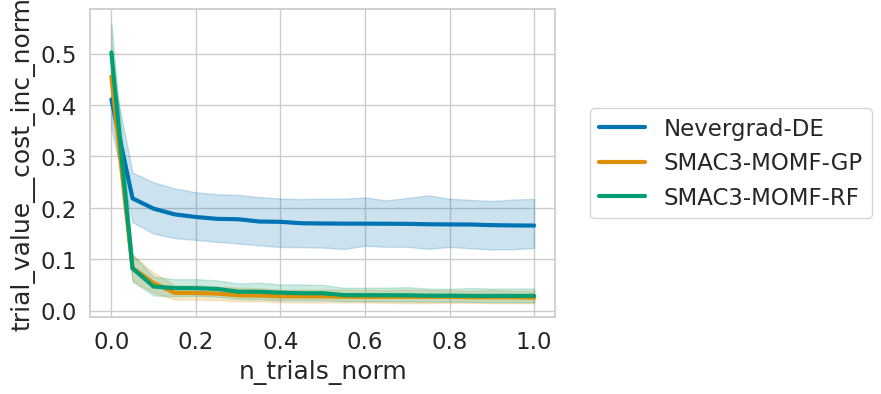

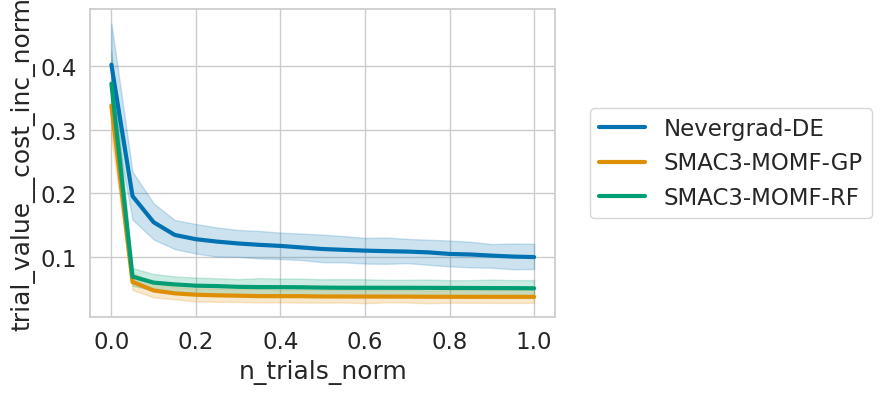

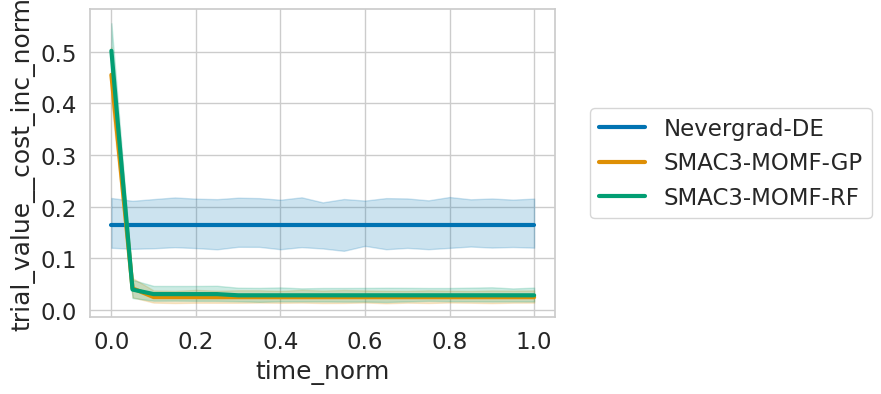

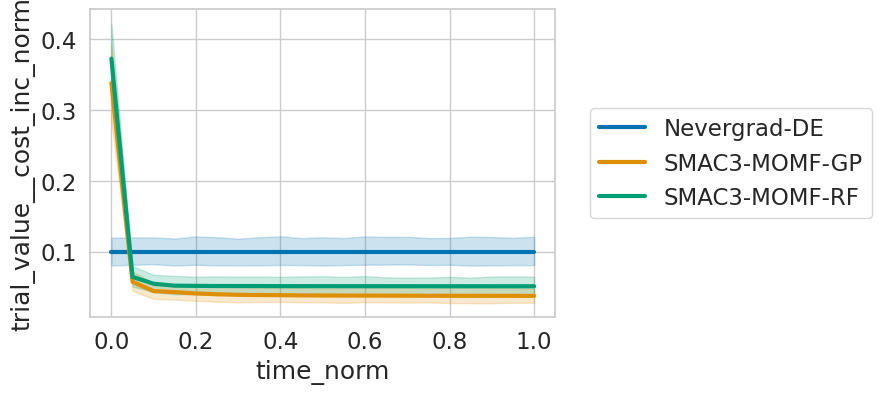

In [ ]:
from carps.analysis.performance_over_time import plot_performance_over_time, setup_seaborn, savefig, get_color_palette
import seaborn as sns
import matplotlib
lineplot_kwargs = dict(linewidth=3)
for gid, gdf in perf.groupby(by=["scenario", "set"]):
    print(gid)
    fig, ax = plot_performance_over_time(
        df=gdf, 
        x="n_trials_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/perf_over_time/performance_over_time_{gid}_trials.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )
for gid, gdf in perf_time.groupby(by=["scenario", "set"]):
    print(gid)
    fig, ax = plot_performance_over_time(
        df=gdf, 
        x="time_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/perf_over_time/performance_over_time_{gid}_elapsed.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )

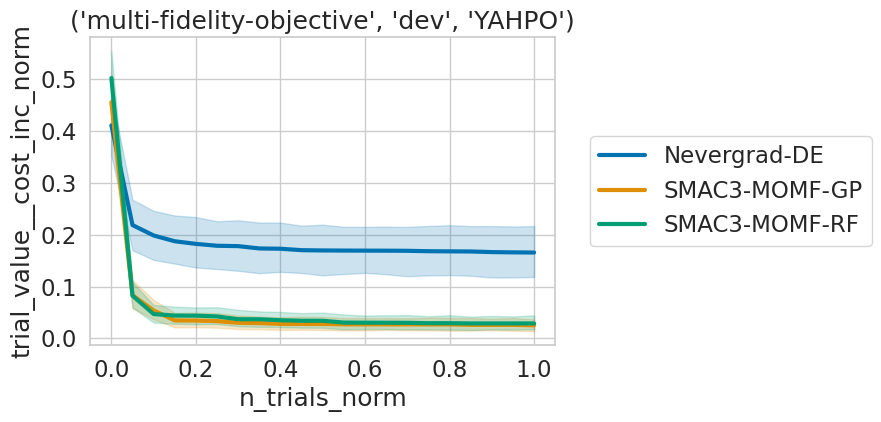

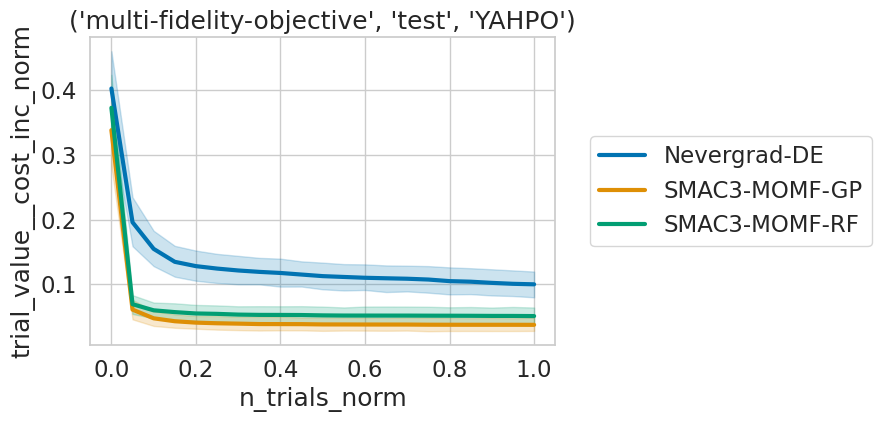

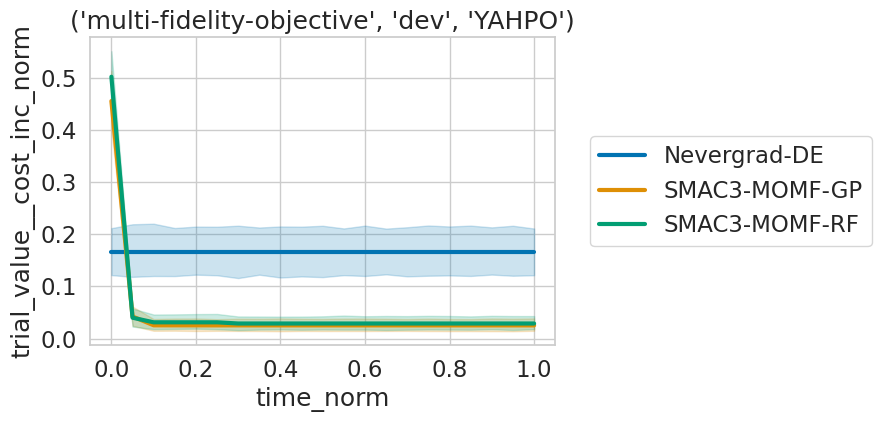

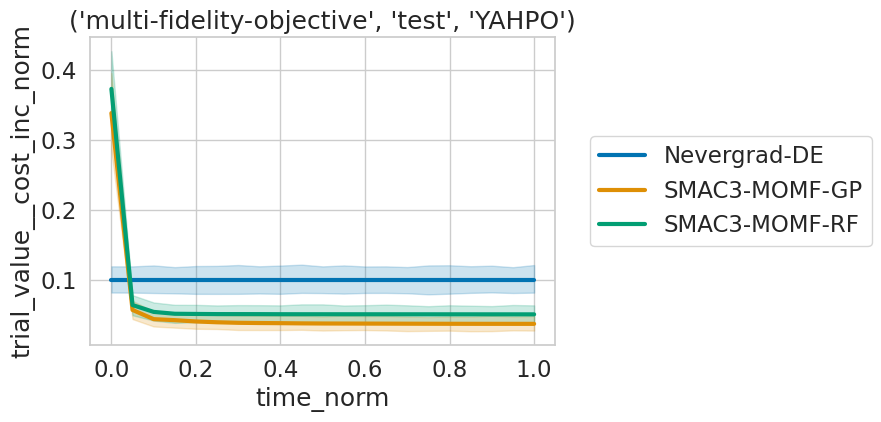

In [ ]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict(linewidth=3)

for gid, gdf in perf.groupby(by=["scenario", "set", "benchmark_id"]):
    # Iterations
    figure_filename = f"figures/perf_over_time/performance_over_time_trials_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=gdf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

# Elapsed time
for gid, gdf in perf_time.groupby(by=["scenario", "set", "benchmark_id"]):    
    figure_filename = f"figures/perf_over_time/performance_over_time_elapsed_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=gdf, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

('multi-fidelity-objective', 'dev')
('multi-fidelity-objective', 'test')


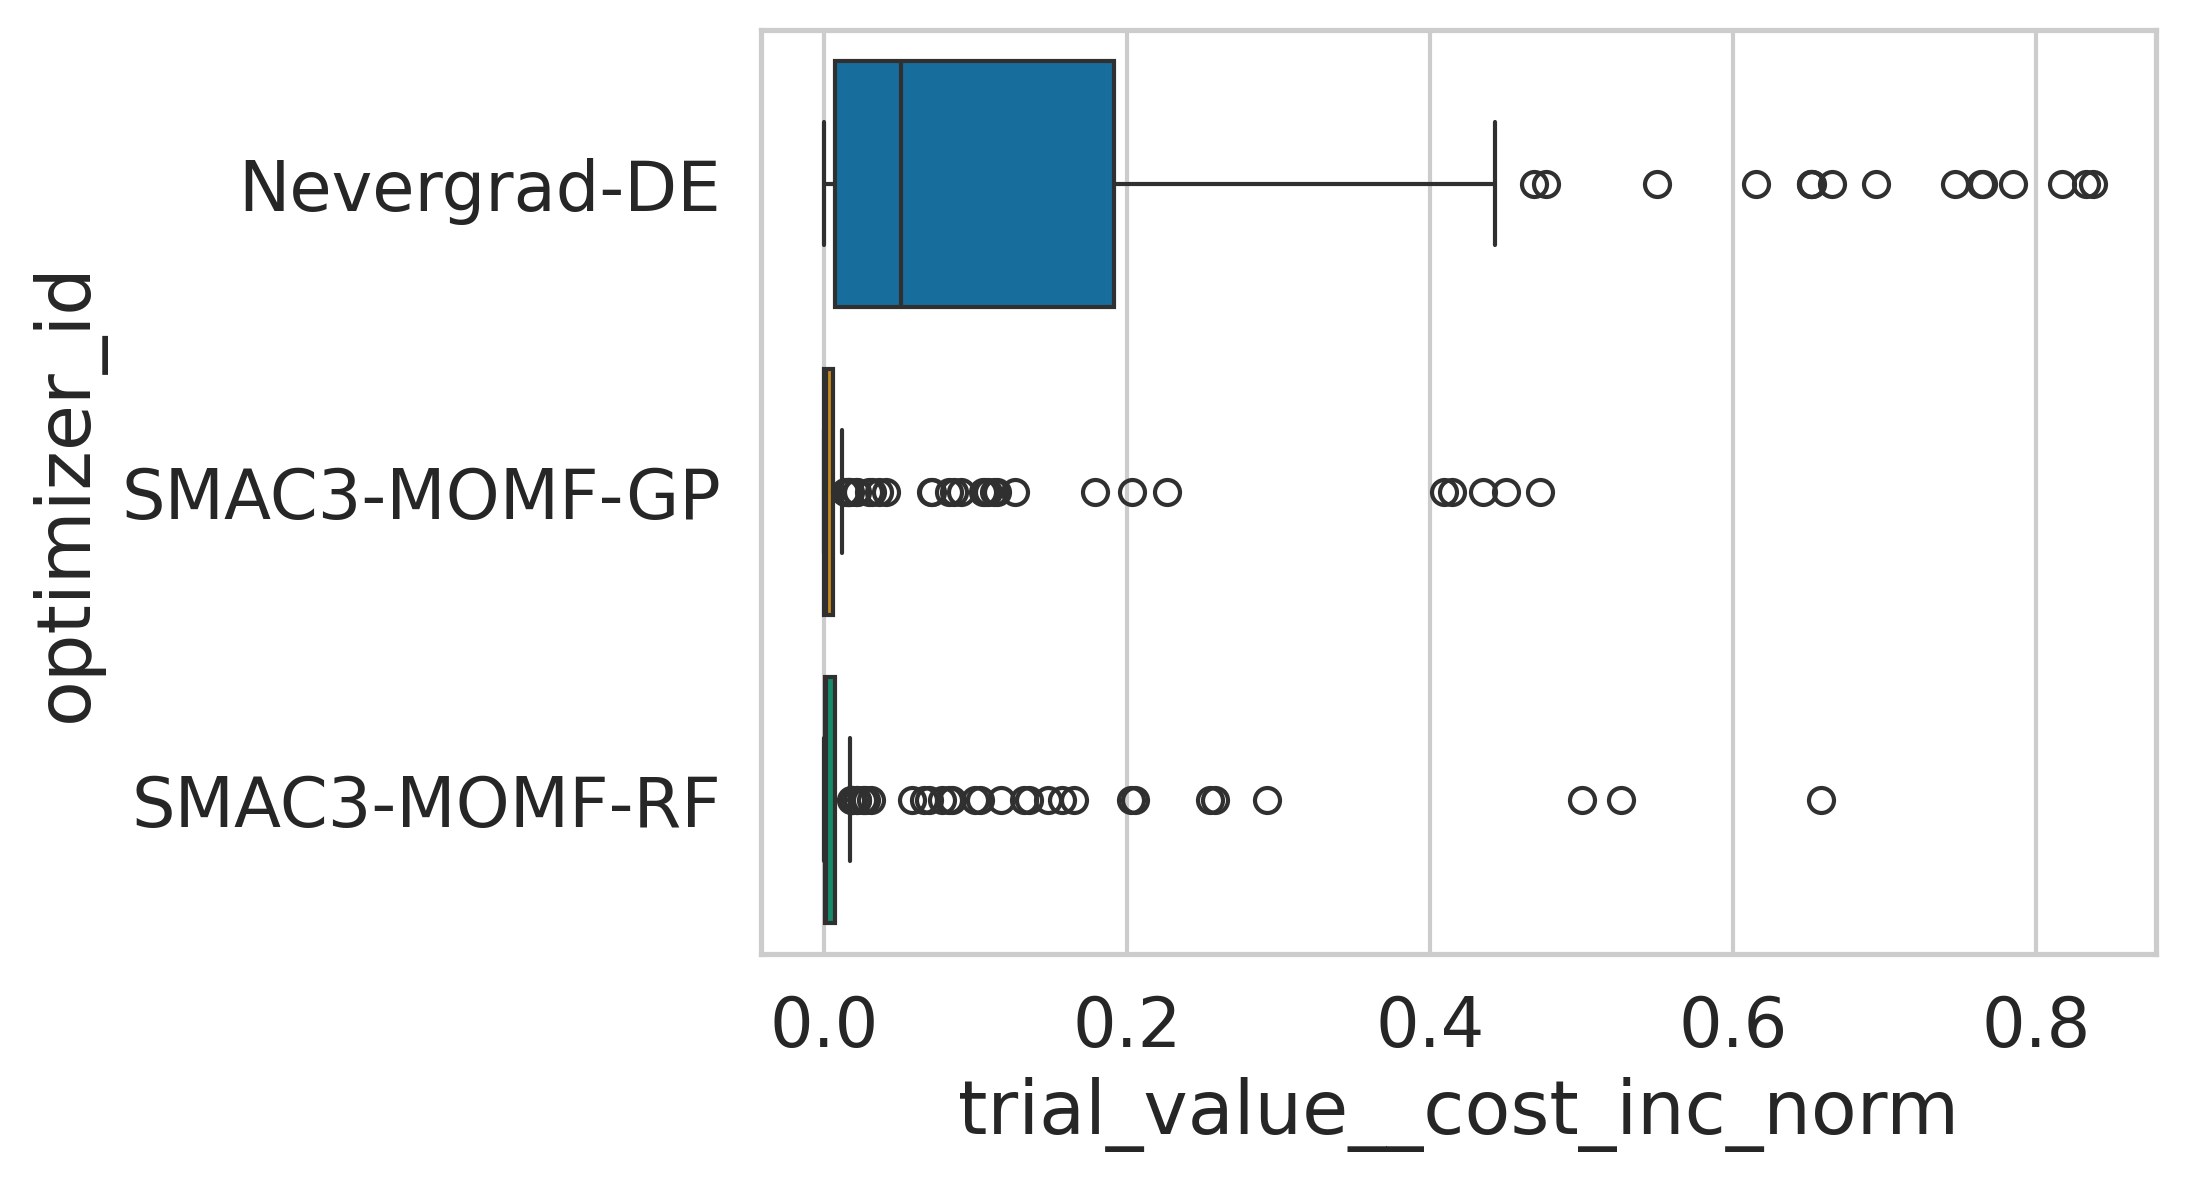

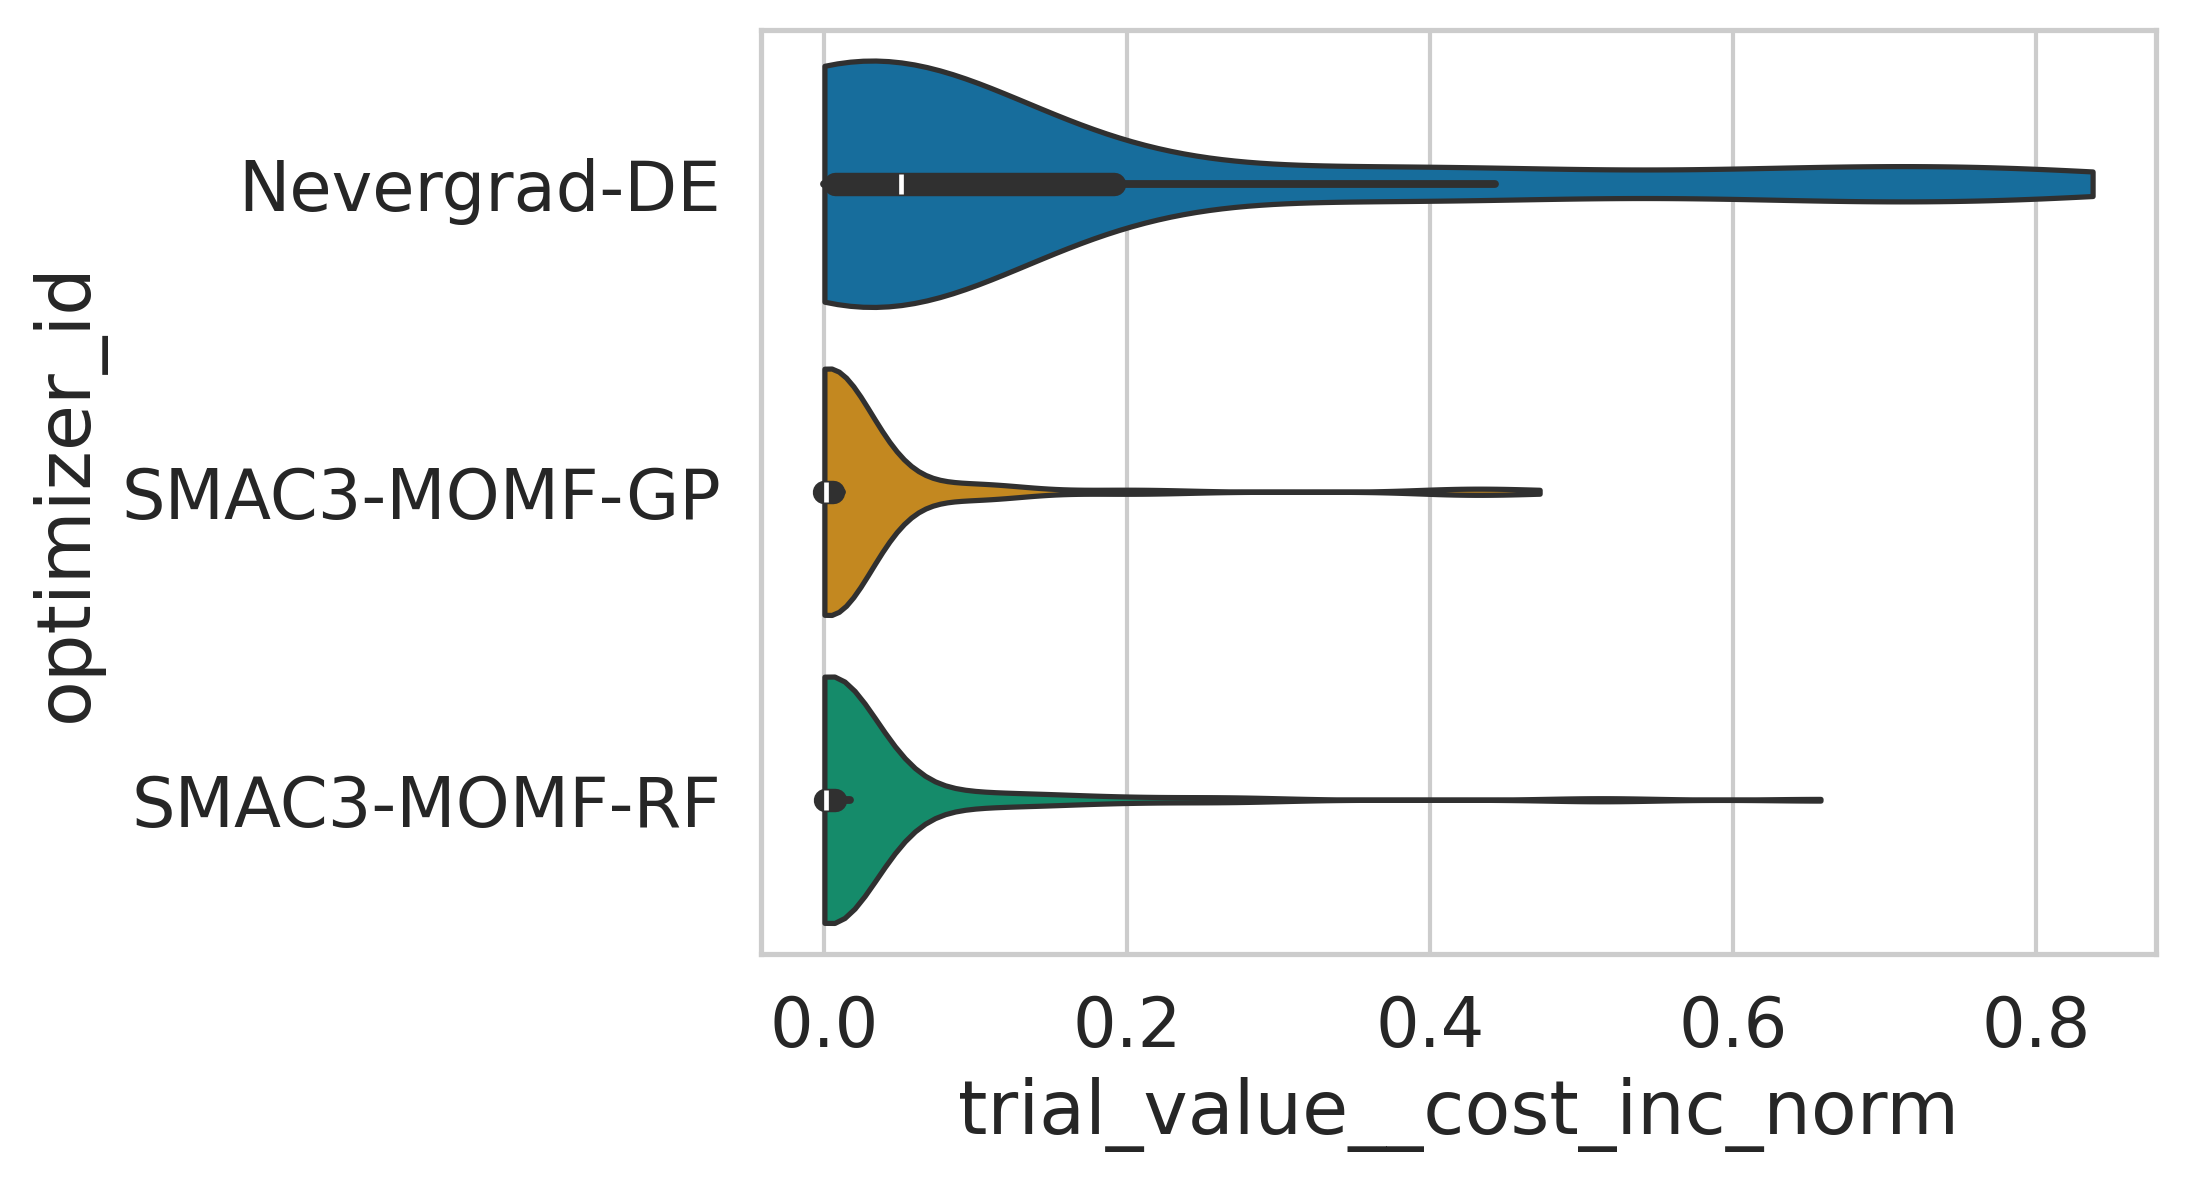

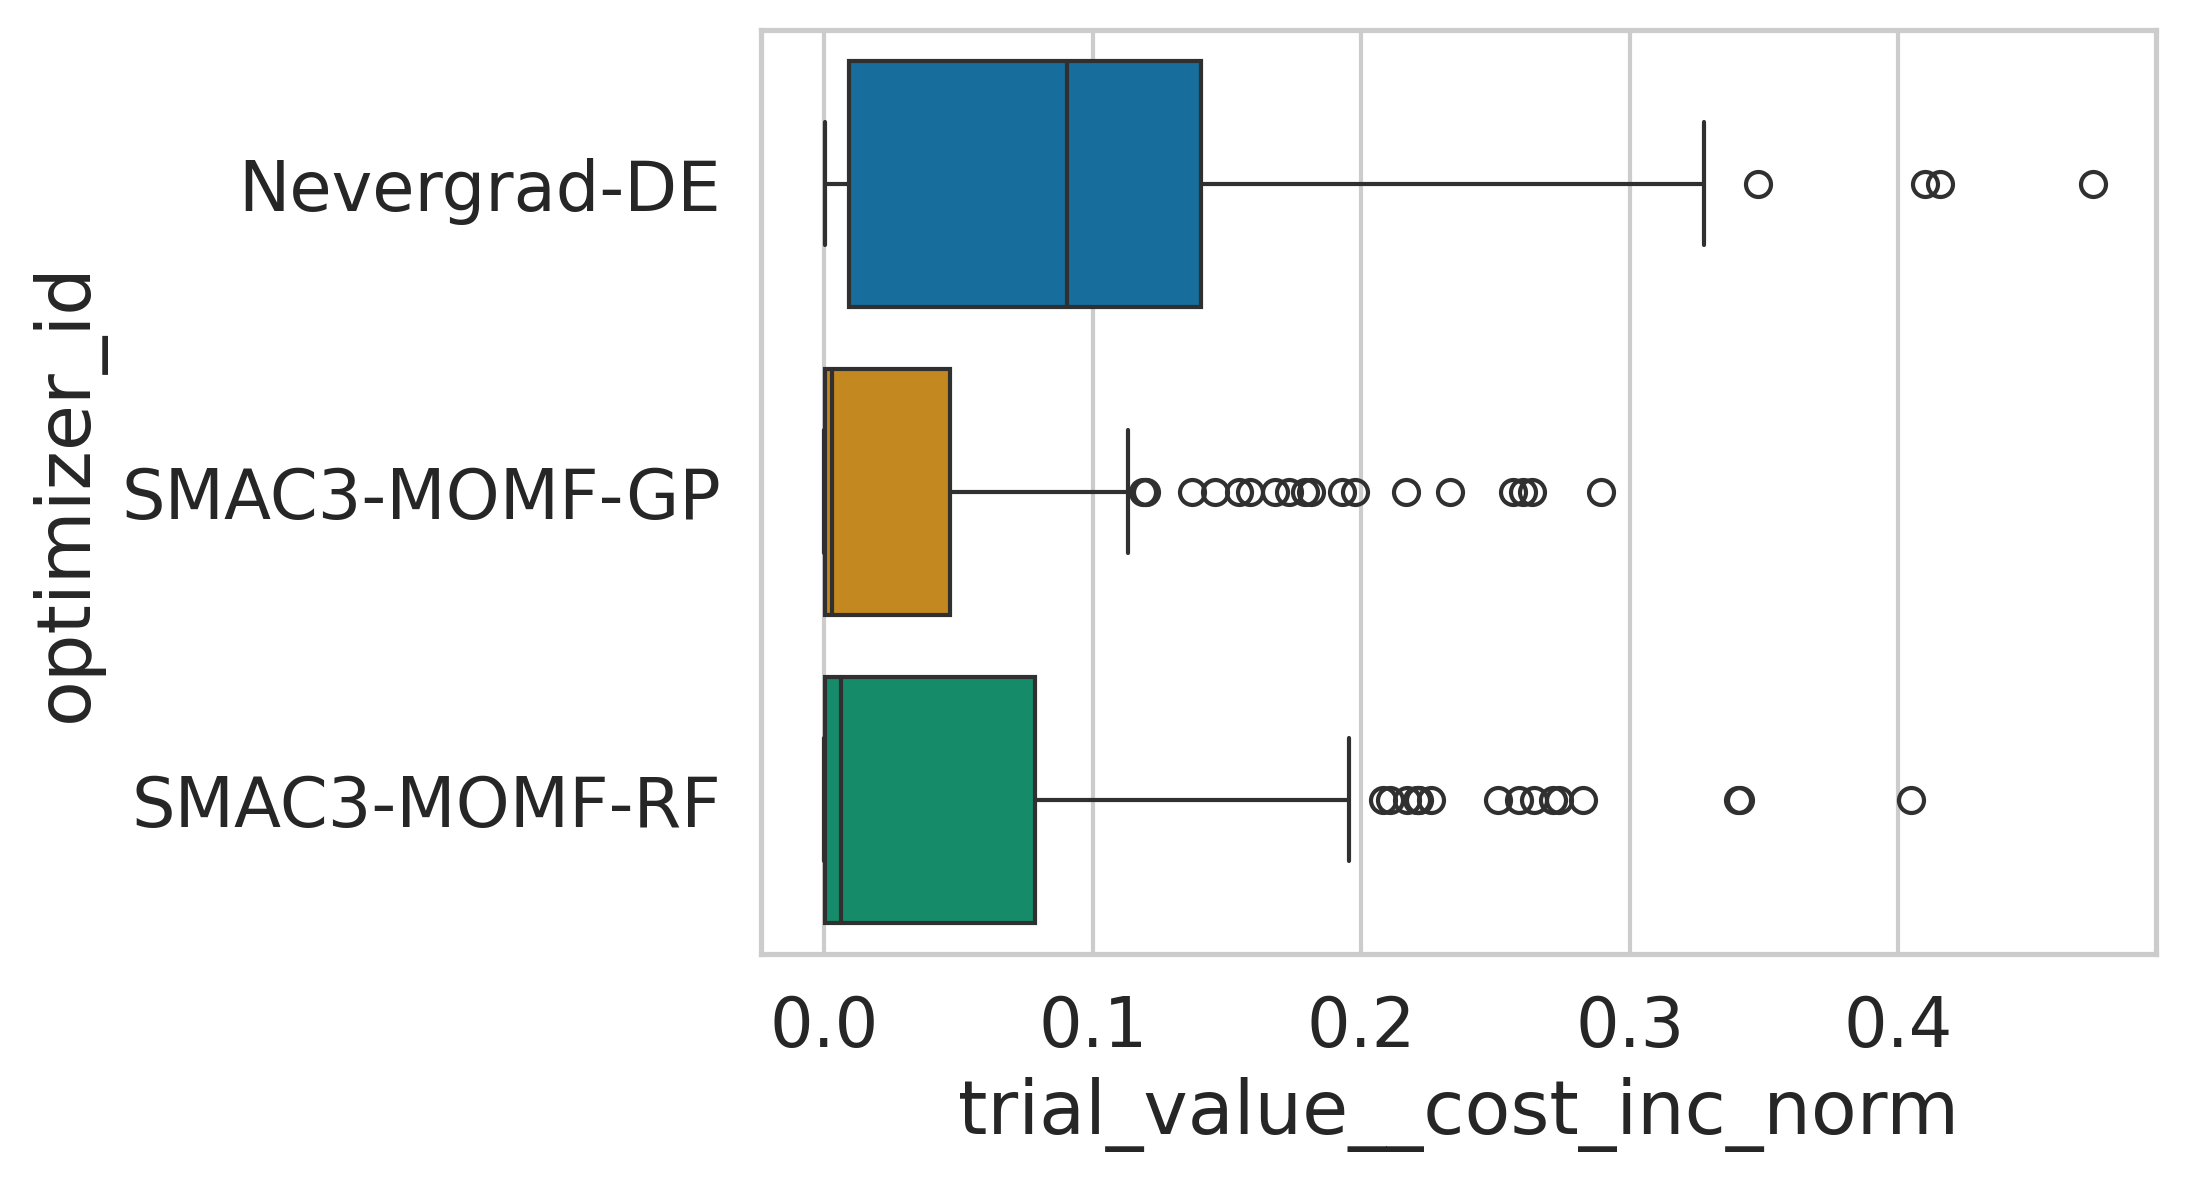

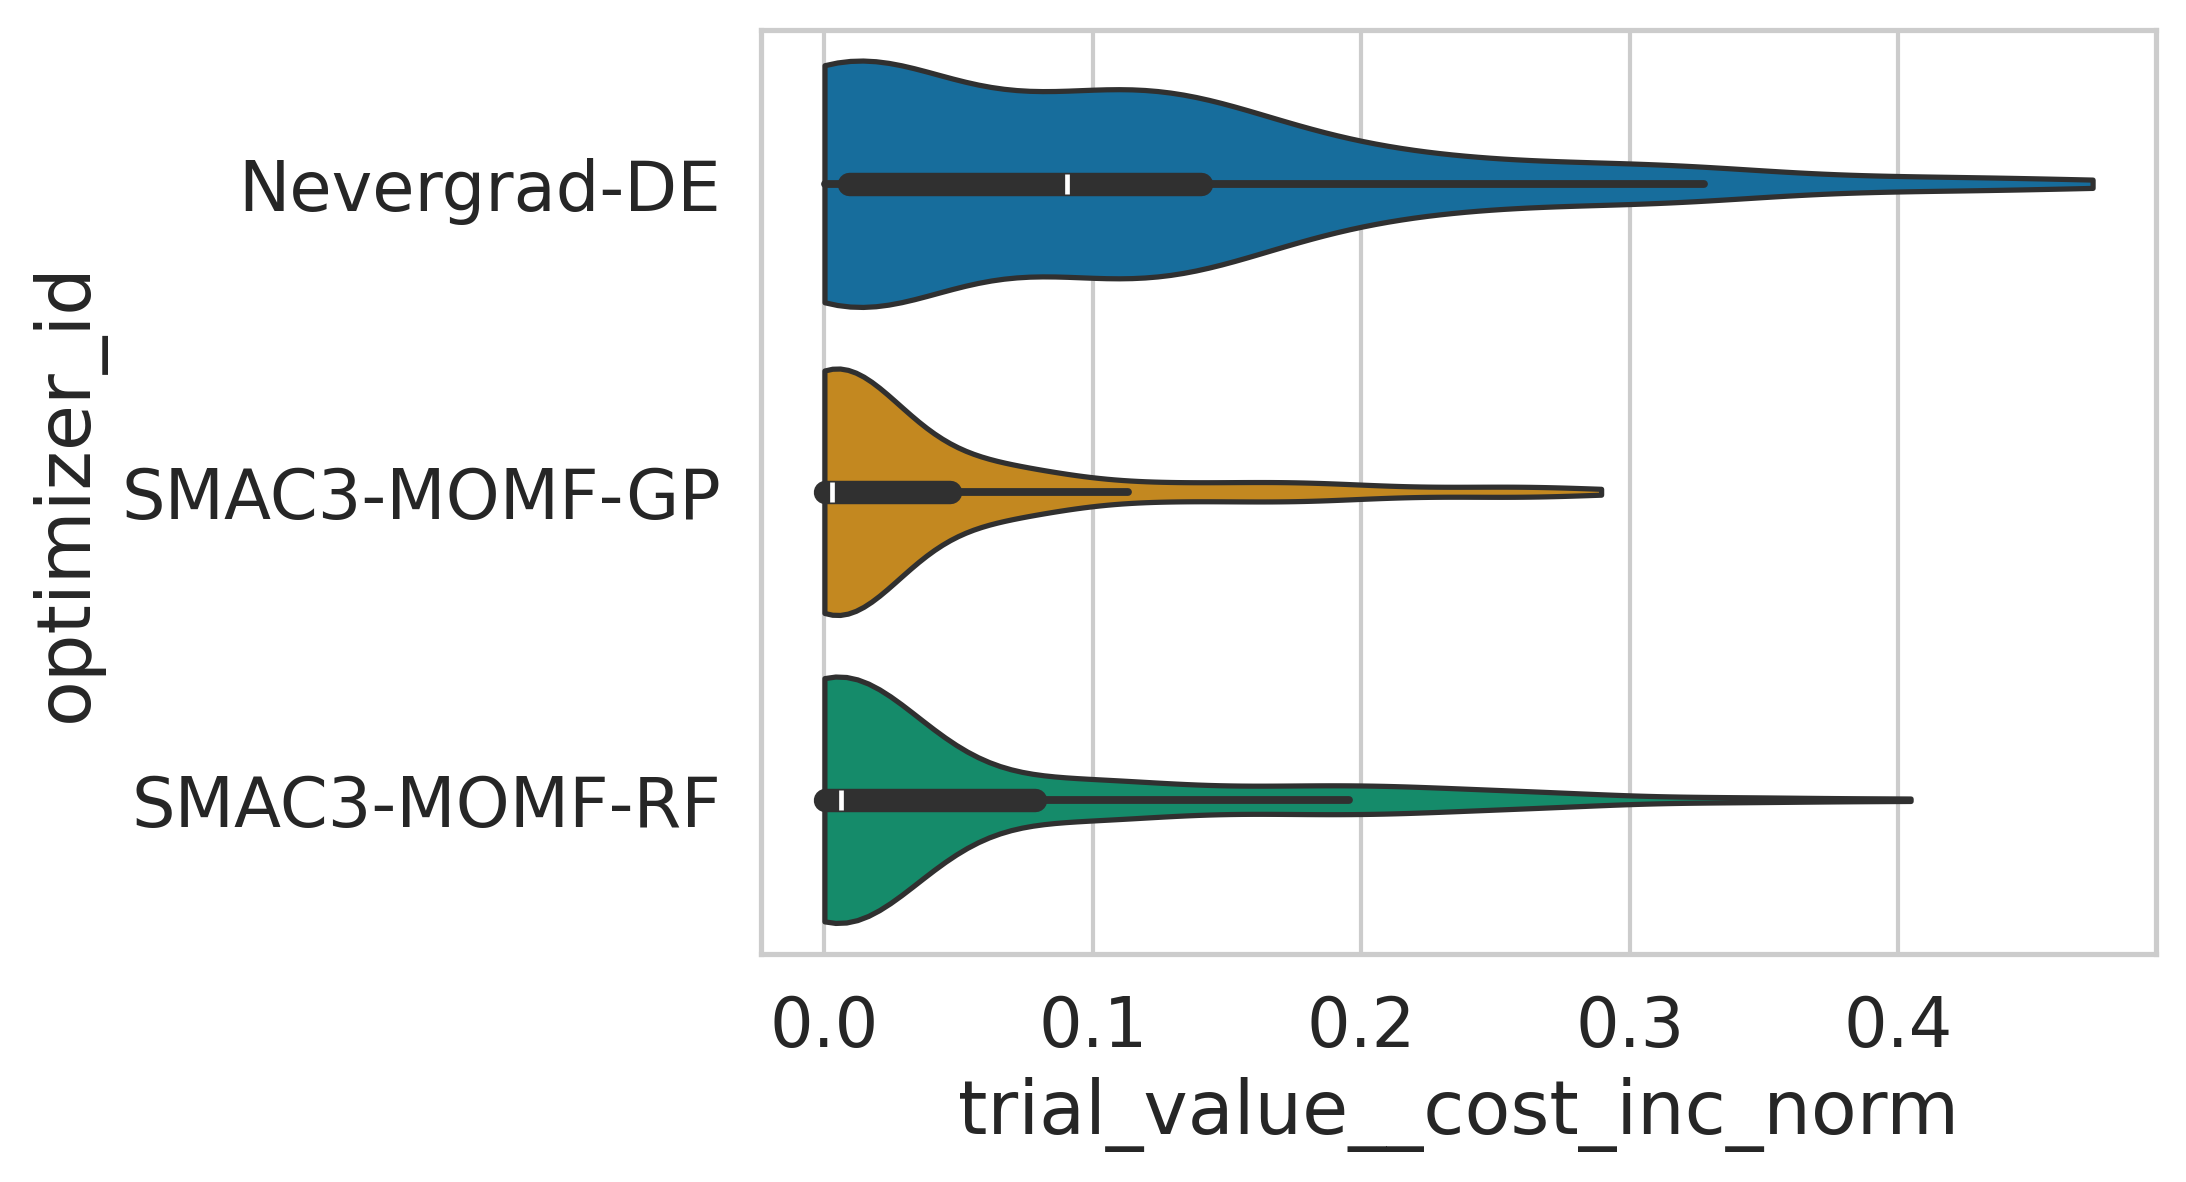

In [ ]:
from carps.analysis.final_performance import plot_final_performance_boxplot, plot_final_performance_violinplot
from carps.analysis.utils import filter_only_final_performance

boxplot_kwargs = dict()

for gid, gdf in perf.groupby(by=["scenario", "set"]):
    print(gid)
    fig, ax = plot_final_performance_boxplot(
        df=gdf, 
        x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename=f"figures/final_perf/final_performance_boxplot_{gid}.pdf", figsize=(6,4), **boxplot_kwargs)
    fig, ax = plot_final_performance_violinplot(
        df=gdf, 
        x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename=f"figures/final_perf/final_performance_violinplot_{gid}.pdf", figsize=(6,4), **boxplot_kwargs)

In [ ]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 1)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 2)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 3)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 4)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 6)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 8)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 9)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 10)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 11)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 12)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 13)
('YAHPO', 'momf/9/dev/yahpo/MOMF/epoch/lcbench/167185/epoch', 'Nevergrad-DE', 14)
('YAHPO', 'momf/9/dev/y